In [0]:
! pip install -q kaggle

In [0]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
! cp "kaggle.json" ~/.kaggle/

In [0]:
! mkdir train

In [0]:
! unzip fruits.zip -d train

In [0]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
import os
import matplotlib.pyplot as plt
import numpy as np

In [0]:
train_data_dir = './train/fruits-360/Training'
validation_data_dir = './train/fruits-360/Test'

In [0]:
img_rows, img_cols = 100,100
batch_size = 32

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 60486 images belonging to 120 classes.
Found 20618 images belonging to 120 classes.


In [0]:
num_classes = 120 

In [0]:
class CNN_Network:
	@staticmethod
	def build(width, height, depth, classes):
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
  
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.25))

		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [0]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
checkpoint = ModelCheckpoint("./weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
#                               factor = 0.2,
#                               patience = 3,
#                               verbose = 1,
#                               min_delta = 0.0001)
callbacks = [checkpoint]

In [0]:
model = CNN_Network.build(width=img_rows, height=img_cols,depth=3, classes=num_classes)
opt = RMSprop()

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"]) 

In [0]:
nb_train_samples = 60486
nb_validation_samples = 20618
epochs = 10

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/15
1890/1890 [==============================] - ETA: 0s - loss: 0.8593 - accuracy: 0.7611
Epoch 00001: val_loss improved from inf to 0.53176, saving model to ./weights.h5
1890/1890 [==============================] - 201s 106ms/step - loss: 0.8593 - accuracy: 0.7611 - val_loss: 0.5318 - val_accuracy: 0.8599
Epoch 2/15
1890/1890 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9343
Epoch 00002: val_loss did not improve from 0.53176
1890/1890 [==============================] - 201s 106ms/step - loss: 0.2112 - accuracy: 0.9343 - val_loss: 0.5343 - val_accuracy: 0.8722
Epoch 3/15
1890/1890 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9584
Epoch 00003: val_loss improved from 0.53176 to 0.34769, saving model to ./weights.h5
1890/1890 [==============================] - 201s 106ms/step - loss: 0.1352 - accuracy: 0.9584 - val_loss: 0.3477 - val_accuracy: 0.9130
Epoch 4/15
1890/1890 [==============================] - ETA: 0s - loss: 0.1055

**Best model's weights is saved, which is at epoch 6.**

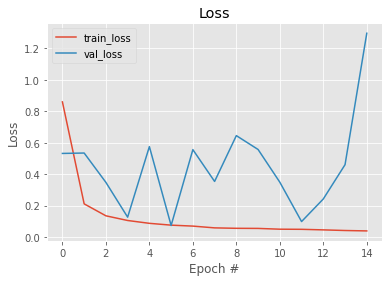

In [0]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

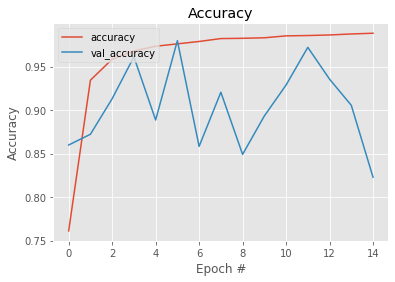

In [0]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

*Loading the model*

In [0]:
model.load_weights("weights.h5")

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib.pyplot import imshow
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [0]:
from google.colab.patches import cv2_imshow

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


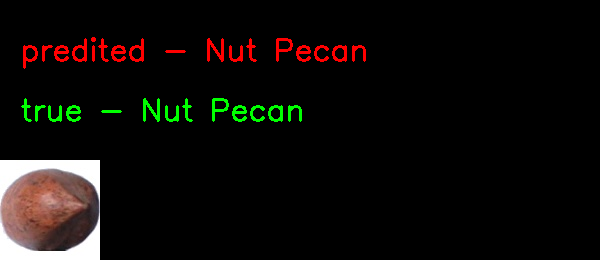

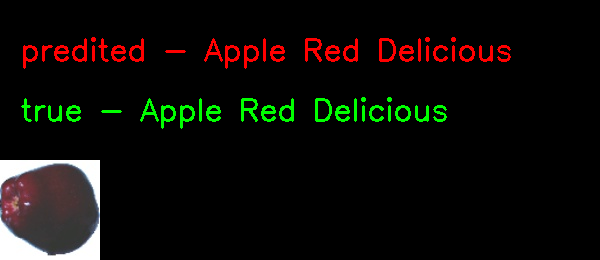

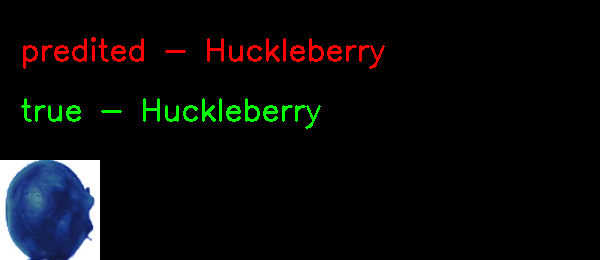

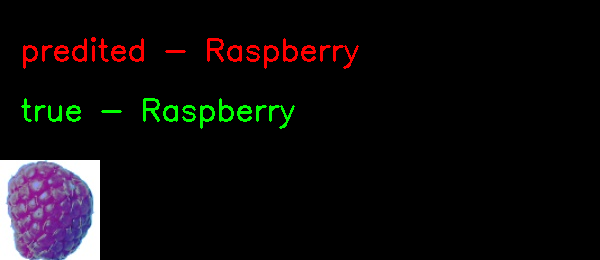

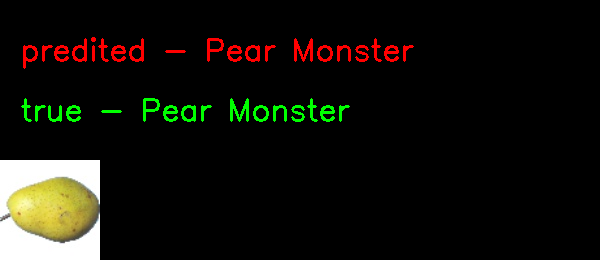

In [0]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2_imshow(expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 100,100


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 5):
    path = './train/fruits-360/Test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 5)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()